In [27]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [32]:
# Define constants
data_dir = 'synthetic'  # Specify the path to your data directory
image_size = (128, 128, 20)  # Image size with depth channel and multiple angles
num_classes = 1  # Number of output classes (child height)
batch_size = 32
epochs = 60

In [15]:
# Function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    for child_id in range(200):  # Child IDs from 000 to 199
        combined_image = None  # Initialize combined image for each child
        text_file_name = f"scene000{child_id:03d}_030.txt"
        for angle in [30, 60, 90, 120, 150]:
            # Create file name
            file_name = f"scene000{child_id:03d}_{angle:03d}.png"
            #print(file_name)

            # Load RGB image
            image_path = os.path.join(data_dir, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load RGB channels
            image = cv2.resize(image, image_size[:2])  # Resize image

            # Load corresponding depth map
            depth_file = file_name.replace('scene', 'depth')
            depth_path = os.path.join(data_dir, depth_file)
            depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)  # Load depth map
            depth = cv2.resize(depth, image_size[:2])  # Resize depth map

            # Stack depth as an additional channel
            combined_single_angle_image = np.dstack((image, depth))

            if combined_image is None:
                combined_image = combined_single_angle_image
            else:
                combined_image = np.concatenate((combined_image, combined_single_angle_image), axis=-1)

        images.append(combined_image)

        # Load corresponding label
        
        label_path = os.path.join(data_dir, text_file_name)
        with open(label_path, 'r') as f:
            label = float(f.read().strip().split(':')[1])
        labels.append(label)

    return np.array(images), np.array(labels)

In [16]:
# Load data
images, labels = load_data(data_dir)

(200,)


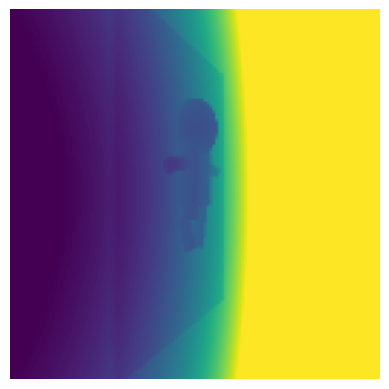

In [22]:
import matplotlib.pyplot as plt
print(labels.shape)
first_image = images[0]
first_layer = first_image[:, :, 19:21]  # Extract the first layer (channel)

# Display the first layer
plt.imshow(first_layer)  # Assuming it's a grayscale image
plt.axis('off')  # Hide axes
plt.show()

In [23]:
# Split data into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

In [39]:
# Define CNN model (updated input shape with batch normalization layers)
def create_model():
    inputs = layers.Input(shape=image_size)

    # Convolutional layers with batch normalization
    conv = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D((2, 2))(conv)
    conv = layers.Conv2D(64, (3, 3), activation='relu')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D((2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D((2, 2))(conv)
    flatten = layers.Flatten()(conv)

    # Fully connected layers
    dense1 = layers.Dense(256, activation='relu')(flatten)
    output = layers.Dense(num_classes)(dense1)

    model = models.Model(inputs=inputs, outputs=output)
    return model

In [36]:
# Define CNN model (updated input shape with batch normalization layers)
def create_model():
    inputs = layers.Input(shape=image_size)

    # Convolutional layers with batch normalization
    conv = layers.Conv2D(32, (3, 3), activation=None)(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.MaxPooling2D((2, 2))(conv)
    conv = layers.Conv2D(64, (3, 3), activation=None)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.MaxPooling2D((2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation=None)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    flatten = layers.Flatten()(conv)

    # Fully connected layers
    dense1 = layers.Dense(256, activation='relu')(flatten)
    output = layers.Dense(num_classes)(dense1)

    model = models.Model(inputs=inputs, outputs=output)
    return model

In [40]:
# Create and compile the model
model = create_model()
model.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
# Train the model
history = model.fit(images_train, labels_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/60
4/4 [==============================] - 1s 293ms/step - loss: 2368.6440 - val_loss: 4215.0645
Epoch 2/60
4/4 [==============================] - 1s 267ms/step - loss: 344.3644 - val_loss: 4160.9727
Epoch 3/60
4/4 [==============================] - 1s 266ms/step - loss: 186.0318 - val_loss: 4221.7280
Epoch 4/60
4/4 [==============================] - 1s 281ms/step - loss: 107.8568 - val_loss: 4112.9404
Epoch 5/60
4/4 [==============================] - 1s 270ms/step - loss: 87.2055 - val_loss: 3784.5789
Epoch 6/60
4/4 [==============================] - 1s 267ms/step - loss: 73.2144 - val_loss: 2016.1650
Epoch 7/60
4/4 [==============================] - 1s 268ms/step - loss: 45.5601 - val_loss: 2145.8701
Epoch 8/60
4/4 [==============================] - 1s 265ms/step - loss: 26.1698 - val_loss: 2010.6865
Epoch 9/60
4/4 [==============================] - 1s 266ms/step - loss: 19.0393 - val_loss: 1918.4241
Epoch 10/60
4/4 [==============================] - 1s 264ms/step - loss: 12.8

KeyboardInterrupt: 

In [34]:
# Evaluate the model
loss = model.evaluate(images_test, labels_test)
print("Test Loss:", loss)
# Predict labels for test set
predictions = model.predict(images_test)

# Calculate accuracy
accuracy = np.mean(np.abs(predictions - labels_test))
print("Test Accuracy (MAE):", accuracy)

2/2 [==============================] - 0s 21ms/step - loss: 6.3394
Test Loss: 6.339400768280029
2/2 [==============================] - 0s 18ms/step
Test Accuracy (MAE): 5.774693090125369


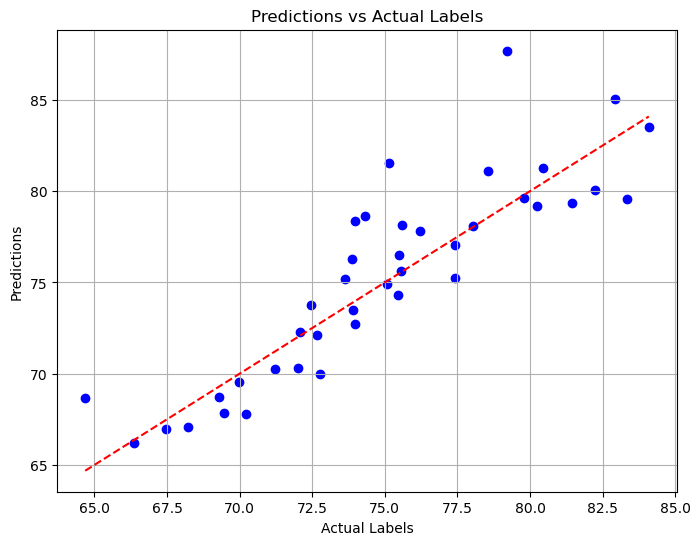

In [35]:
import matplotlib.pyplot as plt

# Plot predictions vs labels_test
plt.figure(figsize=(8, 6))
plt.scatter(labels_test, predictions, color='blue')
plt.plot([min(labels_test), max(labels_test)], [min(labels_test), max(labels_test)], color='red', linestyle='--')
plt.title('Predictions vs Actual Labels')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Plot the distribution of MAE
plt.figure(figsize=(8, 6))
plt.hist(np.abs(predictions - labels_test), bins=20, edgecolor='k')
plt.title('Distribution of Absolute Error')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()